# Identifying safe loans with decision trees

The [LendingClub](https://www.lendingclub.com/) is a peer-to-peer lending company that directly connects borrowers and potential lenders/investors. In this notebook, you will build a classification model to predict whether or not a loan provided by LendingClub is likely to [default](https://en.wikipedia.org/wiki/Default_(finance).

In this notebook you will use data from the LendingClub to predict whether a loan will be paid off in full or the loan will be [charged off](https://en.wikipedia.org/wiki/Charge-off) and possibly go into default. In this assignment you will:

* Use SFrames to do some feature engineering.
* Train a decision-tree on the LendingClub dataset.
* Visualize the tree.
* Predict whether a loan will default along with prediction probabilities (on a validation set).
* Train a complex tree model and compare it to simple tree model.

Copyright ©2018 Emily Fox.  All rights reserved.  Permission is hereby granted to students registered for University of Washington CSE/STAT 416 for use solely during Spring Quarter 2018 for purposes of the course.  No other use, copying, distribution, or modification is permitted without prior written consent. Copyrights for third-party components of this work must be honored.  Instructors interested in reusing these course materials should contact the author.

Let's get started!

In [1]:
import turicreate as tc

import numpy as np
from Util import printTree
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt # for graphing
%matplotlib inline

We will be using a dataset from the [LendingClub](https://www.lendingclub.com/).

In [2]:
loans = tc.SFrame('/data/lending-club-data.gl/')

## Exploring some features

Let's quickly explore what the dataset looks like. First, let's print out the column names to see what features we have in this dataset.

In [3]:
loans.column_names()

['id',
 'member_id',
 'loan_amnt',
 'funded_amnt',
 'funded_amnt_inv',
 'term',
 'int_rate',
 'installment',
 'grade',
 'sub_grade',
 'emp_title',
 'emp_length',
 'home_ownership',
 'annual_inc',
 'is_inc_v',
 'issue_d',
 'loan_status',
 'pymnt_plan',
 'url',
 'desc',
 'purpose',
 'title',
 'zip_code',
 'addr_state',
 'dti',
 'delinq_2yrs',
 'earliest_cr_line',
 'inq_last_6mths',
 'mths_since_last_delinq',
 'mths_since_last_record',
 'open_acc',
 'pub_rec',
 'revol_bal',
 'revol_util',
 'total_acc',
 'initial_list_status',
 'out_prncp',
 'out_prncp_inv',
 'total_pymnt',
 'total_pymnt_inv',
 'total_rec_prncp',
 'total_rec_int',
 'total_rec_late_fee',
 'recoveries',
 'collection_recovery_fee',
 'last_pymnt_d',
 'last_pymnt_amnt',
 'next_pymnt_d',
 'last_credit_pull_d',
 'collections_12_mths_ex_med',
 'mths_since_last_major_derog',
 'policy_code',
 'not_compliant',
 'status',
 'inactive_loans',
 'bad_loans',
 'emp_length_num',
 'grade_num',
 'sub_grade_num',
 'delinq_2yrs_zero',
 'pub_rec

Here, we see that we have some feature columns that have to do with grade of the loan, annual income, home ownership status, etc. Let's take a look at the distribution of loan grades in the dataset.

In [4]:
loans['grade'].show()

Materializing SArray...

Done.

Materializing SArray...

Done.

We can see that over half of the loan grades are assigned values `B` or `C`. Each loan is assigned one of these grades, along with a more finely discretized feature called `subgrade` (feel free to explore that feature column as well!). These values depend on the loan application and credit report, and determine the interest rate of the loan. More information can be found [here](https://www.lendingclub.com/public/rates-and-fees.action).

Now, let's look at a different feature.

In [5]:
loans['home_ownership'].show()

Materializing SArray...

Done.

Materializing SArray...

Done.

This feature describes whether the loanee is mortaging, renting, or owns a home. We can see that a small percentage of the loanees own a home.

## Exploring the target column

The target column (label column) of the dataset that we are interested in is called `bad_loans`. In this column **1** means a risky (bad) loan **0** means a safe  loan.

In order to make this more intuitive and consistent with the lectures, we reassign the target to be:
* **+1** as a safe  loan, 
* **-1** as a risky (bad) loan. 

We put this in a new column called `safe_loans`.

In [6]:
# safe_loans =  1 => safe
# safe_loans = -1 => risky
loans['safe_loans'] = loans['bad_loans'].apply(lambda x : +1 if x==0 else -1)
loans = loans.remove_column('bad_loans')

Using default 16 lambda workers.

To maximize the degree of parallelism, add the following code to the beginning of the program:

"turicreate.config.set_runtime_config('TURI_DEFAULT_NUM_PYLAMBDA_WORKERS', 24)"

Note that increasing the degree of parallelism also increases the memory footprint.

Now, let us explore the distribution of the column `safe_loans`. This gives us a sense of how many safe and risky loans are present in the dataset.

In [7]:
only_safe = loans[loans['safe_loans'] == 1]
only_bad = loans[loans['safe_loans'] == -1]
print('num safe loans: {} ({}%)'.format(len(only_safe), len(only_safe) * 100.0 / len(loans)))
print('num safe loans: {} ({}%)'.format(len(only_bad), len(only_bad) * 100.0 / len(loans)))

num safe loans: 99457 (81.1185331996%)
num safe loans: 23150 (18.8814668004%)


You should have:
* Around 81% safe loans
* Around 19% risky loans

It looks like most of these loans are safe loans (thankfully). But this does make our problem of identifying risky loans challenging.

## Features for the classification algorithm

In this assignment, we will be using a subset of features (categorical and numeric). The features we will be using are **described in the code comments** below. If you are a finance geek, the [LendingClub](https://www.lendingclub.com/) website has a lot more details about these features.

In [8]:
features = ['grade',                     # grade of the loan
            'sub_grade',                 # sub-grade of the loan
            'short_emp',                 # one year or less of employment
            'emp_length_num',            # number of years of employment
            'home_ownership',            # home_ownership status: own, mortgage or rent
            'dti',                       # debt to income ratio
            'purpose',                   # the purpose of the loan
            'term',                      # the term of the loan
            'last_delinq_none',          # has borrower had a delinquincy
            'last_major_derog_none',     # has borrower had 90 day or worse rating
            'revol_util',                # percent of available credit being used
            'total_rec_late_fee',        # total late fees received to day
           ]

target = 'safe_loans'                   # prediction target (y) (+1 means safe, -1 is risky)

# Extract the feature columns and target column
loans = loans[features + [target]]

What remains now is a **subset of features** and the **target** that we will use for the rest of this notebook. 

## Sample data to balance classes

As we explored above, our data is disproportionally full of safe loans.  Let's create two datasets: one with just the safe loans (`safe_loans_raw`) and one with just the risky loans (`risky_loans_raw`).

In [9]:
safe_loans_raw = loans[loans[target] == +1]
risky_loans_raw = loans[loans[target] == -1]
print "Number of safe loans  : %s" % len(safe_loans_raw)
print "Number of risky loans : %s" % len(risky_loans_raw)

Number of safe loans  : 99457
Number of risky loans : 23150


One way to combat class imbalance is to undersample the larger class until the class distribution is approximately half and half. Here, we will undersample the larger class (safe loans) in order to balance out our dataset. This means we are throwing away many data points. We used `seed=1` so everyone gets the same results.

In [10]:
# Since there are fewer risky loans than safe loans, find the ratio of the sizes
# and use that percentage to undersample the safe loans.
percentage = len(risky_loans_raw)/float(len(safe_loans_raw))

risky_loans = risky_loans_raw
safe_loans = safe_loans_raw.sample(percentage, seed=1)

# Append the risky_loans with the downsampled version of safe_loans
loans_data = risky_loans.append(safe_loans)


Now, let's verify that the resulting percentage of safe and risky loans are each nearly 50%.

In [11]:
print "Percentage of safe loans                 :", len(safe_loans) / float(len(loans_data))
print "Percentage of risky loans                :", len(risky_loans) / float(len(loans_data))
print "Total number of loans in our new dataset :", len(loans_data)

Percentage of safe loans                 : 0.502236174422
Percentage of risky loans                : 0.497763825578
Total number of loans in our new dataset : 46508


**Note:** There are many approaches for dealing with imbalanced data, including some where we modify the learning algorithm. These approaches are beyond the scope of this course, but some of them are reviewed in this [paper](http://ieeexplore.ieee.org/xpl/login.jsp?tp=&arnumber=5128907&url=http%3A%2F%2Fieeexplore.ieee.org%2Fiel5%2F69%2F5173046%2F05128907.pdf%3Farnumber%3D5128907 ). For this assignment, we use the simplest possible approach, where we subsample the overly represented class to get a more balanced dataset. In general, and especially when the data is highly imbalanced, we recommend using more advanced methods.

## Split data into training and validation sets

We split the data into training and validation sets using an 80/20 split and specifying `seed=1` so everyone gets the same results.

**Note**: Remember that we are dividing this data into training and validation sets because the portion of data that we don't train on will be used to help **select model parameters** (this is known as model selection). Thus, this portion of data should be called a **validation set**. Recall that examining performance of various potential models (i.e. models with different parameters) should be on validation set, while evaluation of the final selected model should always be on test data. Typically, we would also save a portion of the data (a real test set) to test our final model on or use cross-validation on the training set to select our final model. But for the learning purposes of this assignment, we won't do that.

In [12]:
train_data, validation_data = loans_data.random_split(.8, seed=1)

# Use decision tree to build a classifier

Now, let's use the built-in [Turi Create decision tree learner](https://apple.github.io/turicreate/docs/api/generated/turicreate.decision_tree_classifier.create.html#turicreate.decision_tree_classifier.create) to create a loan prediction model on the training data. 
* Use the features and target defined earlier
* Use `validation_set=None`

In [13]:
decision_tree_model = tc.decision_tree_classifier.create(train_data, target='safe_loans', validation_set=None)


Decision tree classifier:

--------------------------------------------------------

Number of examples          : 37224

Number of classes           : 2

Number of feature columns   : 12

Number of unpacked features : 12

+-----------+--------------+-------------------+-------------------+

| Iteration | Elapsed Time | Training-accuracy | Training-log_loss |

+-----------+--------------+-------------------+-------------------+

| 1         | 0.069171     | 0.640581          | 0.631396          |

+-----------+--------------+-------------------+-------------------+

## Visualizing a learned model

As noted in the [documentation](https://dato.com/products/create/docs/generated/graphlab.boosted_trees_classifier.create.html#graphlab.boosted_trees_classifier.create), typically the the max depth of the tree is capped at 6. However, such a tree can be hard to visualize graphically.  Here, we instead learn a smaller model with **max depth of 2** to gain some intuition by visualizing the learned tree.

In [14]:
small_model = tc.decision_tree_classifier.create(train_data, validation_set=None,
                   target = target, features = features, max_depth = 2)

Decision tree classifier:

--------------------------------------------------------

Number of examples          : 37224

Number of classes           : 2

Number of feature columns   : 12

Number of unpacked features : 12

+-----------+--------------+-------------------+-------------------+

| Iteration | Elapsed Time | Training-accuracy | Training-log_loss |

+-----------+--------------+-------------------+-------------------+

| 1         | 0.023737     | 0.613502          | 0.658759          |

+-----------+--------------+-------------------+-------------------+

We've included a method in the `Util.py` file for visualizing a learned decision tree. This visualization is great for considering the evaluation process when this model predicts the target of a new data point.

In this visual:
* The root node is at the top of the diagram
* reddish-pink nodes are unsafe, blue nodes are safe

**Note**: the values at the leaf nodes are not class predictions but scores (a slightly advanced concept that is out of the scope of this course). You can read more about this [here](https://homes.cs.washington.edu/~tqchen/pdf/BoostedTree.pdf).  If the score is $\geq$ 0, the class +1 is predicted.  Otherwise, if the score < 0, we predict class -1.

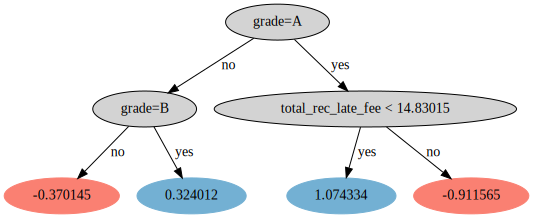

In [15]:
printTree(small_model)

# Making predictions

Let's consider two positive and two negative examples **from the validation set** and see what the model predicts. We will do the following:
* Predict whether or not a loan is safe.
* Predict the probability that a loan is safe.

In [16]:
validation_safe_loans = validation_data[validation_data[target] == 1]
validation_risky_loans = validation_data[validation_data[target] == -1]

sample_validation_data_risky = validation_risky_loans[0:2]
sample_validation_data_safe = validation_safe_loans[0:2]

sample_validation_data = sample_validation_data_safe.append(sample_validation_data_risky)
sample_validation_data

Columns:
	grade	str
	sub_grade	str
	short_emp	int
	emp_length_num	int
	home_ownership	str
	dti	float
	purpose	str
	term	str
	last_delinq_none	int
	last_major_derog_none	int
	revol_util	float
	total_rec_late_fee	float
	safe_loans	int

Rows: 4

Data:
+-------+-----------+-----------+----------------+----------------+-------+
| grade | sub_grade | short_emp | emp_length_num | home_ownership |  dti  |
+-------+-----------+-----------+----------------+----------------+-------+
|   B   |     B3    |     0     |       11       |      OWN       | 11.18 |
|   D   |     D1    |     0     |       10       |      RENT      | 16.85 |
|   D   |     D2    |     0     |       3        |      RENT      | 13.97 |
|   A   |     A5    |     0     |       11       |    MORTGAGE    | 16.33 |
+-------+-----------+-----------+----------------+----------------+-------+
+--------------------+------------+------------------+-----------------------+
|      purpose       |    term    | last_delinq_none | last_major_derog_none |
+--------------------+------------+------------------+-----------------------+
|    credit_card     |  36 months |        1         |           1           |
| debt_consolidation |  36 months |        1         |           1           |
|       other        |  60 months |        0         |           1           |
| debt_consolidation |  36 months |        1         |           1           |
+--------------------+------------+------------------+-----------------------+
+------------+--------------------+------------+
| revol_util | total_rec_late_fee | safe_loans |
+------------+--------------------+------------+
|    82.4    |        0.0         |     1      |
|    96.4    |        0.0         |     1      |
|    59.5    |        0.0         |     -1     |
|    62.1    |        0.0         |     -1     |
+------------+--------------------+------------+
[4 rows x 13 columns]

## Explore label predictions

Now, we will use our model  to predict whether or not a loan is likely to default. For each row in the **sample_validation_data**, use the **decision_tree_model** to predict whether or not the loan is classified as a **safe loan**. 

**Hint:** Be sure to use the `.predict()` method.

In [18]:
for row in sample_validation_data:
    print(decision_tree_model.predict(row))
 

[1]
[-1]
[-1]
[1]


### Q1) What percentage of the predictions on `sample_validation_data` did `decision_tree_model` get correct?

- 0%
- 25%
- 50%
- 75%
- 100%

## Explore probability predictions

For each row in the **sample_validation_data**, what is the probability (according to **decision_tree_model**) of a loan being classified as **safe**? 


**Hint:** Set `output_type='probability'` to make **probability** predictions using **decision_tree_model** on `sample_validation_data`:

In [19]:
for row in sample_validation_data:
    print(decision_tree_model.predict(row, output_type='probability'))

[0.6532223224639893]
[0.463798463344574]
[0.356814444065094]
[0.7621196508407593]


### Q2) Which loan has the highest probability of being classified as a **safe loan**? (Go by index, eg loan 0 is the loan in the 0th index of sample_validation_data)

- Loan 0
- Loan 1
- Loan 2
- Loan 3


### Q3) What classification do the predictions with `probability > 0.5` have?
- -1
- 0
- +1

### Tricky predictions!

Now, we will explore something pretty interesting. For each row in the **sample_validation_data**, what is the probability (according to **small_model**) of a loan being classified as **safe**?

**Hint:** Set `output_type='probability'` to make **probability** predictions using **small_model** on `sample_validation_data`:

In [20]:
for row in sample_validation_data:
    print(small_model.predict(row, output_type='probability'))

[0.5803016424179077]
[0.4085058867931366]
[0.4085058867931366]
[0.7454202175140381]


### Q4) Notice that the probability predictions are the **exact same** for the 2nd and 3rd loans i.e `0.4085058867931366`. Why would this happen?

## Visualize the prediction on a tree


Note that you should be able to look at the small tree, traverse it yourself, and visualize the prediction being made. Consider the following point in the **sample_validation_data**

In [21]:
sample_validation_data[1]

{'dti': 16.85,
 'emp_length_num': 10,
 'grade': 'D',
 'home_ownership': 'RENT',
 'last_delinq_none': 1,
 'last_major_derog_none': 1,
 'purpose': 'debt_consolidation',
 'revol_util': 96.4,
 'safe_loans': 1,
 'short_emp': 0,
 'sub_grade': 'D1',
 'term': ' 36 months',
 'total_rec_late_fee': 0.0}

Let's visualize the small tree here to do the traversing for this data point.

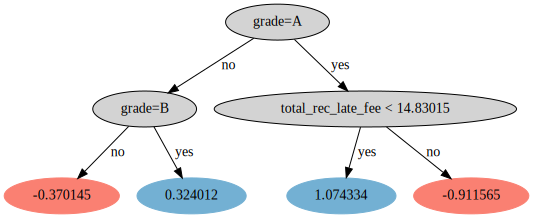

In [22]:
printTree(small_model)

### Q5) Based on the visualized tree, what prediction would you make for this data point?
- -1
- 0
- +1

Now, let's verify your prediction by examining the prediction made using Turi Create.  Use the `.predict` function on `small_model`.

In [23]:
print(small_model.predict(sample_validation_data[1]))

[-1]


# Evaluating accuracy of the decision tree model

Recall that the accuracy is defined as follows:
$$
\mbox{accuracy} = \frac{\mbox{# correctly classified examples}}{\mbox{# total examples}}
$$

Let us start by evaluating the accuracy of the `small_model` and `decision_tree_model` on the training data. If you aren't sure how to get accuracy, check the [docs](https://apple.github.io/turicreate/docs/api/generated/turicreate.decision_tree_classifier.DecisionTreeClassifier.evaluate.html?highlight=evaluate#turicreate.decision_tree_classifier.DecisionTreeClassifier.evaluate).

In [24]:
accuracy_small_model_ts = small_model.evaluate(train_data, metric='accuracy')
print(accuracy_small_model_ts)

{'accuracy': 0.6135020416935311}


You should see that the **small_model** performs worse than the **decision_tree_model** on the training data.

### Q6) what is the accuracy of the `small_model` on the training data, rounded to the nearest .01?


Now, let us evaluate the accuracy of the **small_model** and **decision_tree_model** on the entire **validation_data**, not just the subsample considered above:

### Q7) What is the accuracy of `decision_tree_model` on the validation set, rounded to the nearest .01?

In [25]:
accuracy_decision_tree_model_vs = decision_tree_model.evaluate(validation_data, metric='accuracy')
print(accuracy_decision_tree_model_vs)

{'accuracy': 0.6367944851357173}


## Evaluating accuracy of a complex decision tree model

Here, we will train a large decision tree with `max_depth=10`. This will allow the learned tree to become very deep, and result in a very complex model. Recall that in lecture, we prefer simpler models with similar predictive power. This will be an example of a more complicated model which has similar predictive power, i.e. something we don't want.

In [26]:
big_model = tc.decision_tree_classifier.create(train_data, validation_set=None,
                   target = target, features = features, max_depth = 10)

Decision tree classifier:

--------------------------------------------------------

Number of examples          : 37224

Number of classes           : 2

Number of feature columns   : 12

Number of unpacked features : 12

+-----------+--------------+-------------------+-------------------+

| Iteration | Elapsed Time | Training-accuracy | Training-log_loss |

+-----------+--------------+-------------------+-------------------+

| 1         | 0.113486     | 0.665538          | 0.606828          |

+-----------+--------------+-------------------+-------------------+

Now, let us evaluate **big_model** on the training set and validation set.

In [27]:
accuracy_big_model_vs = big_model.evaluate(validation_data, metric='accuracy')
print(accuracy_big_model_vs)

accuracy_big_model_ts = big_model.evaluate(train_data, metric='accuracy')
print(accuracy_big_model_ts)

accuracy_decision_tree_model_ts = decision_tree_model.evaluate(train_data, metric='accuracy')
print(accuracy_decision_tree_model_ts)

{'accuracy': 0.6274235243429557}
{'accuracy': 0.665538362346873}
{'accuracy': 0.6405813453685794}


We should see that **big_model** has even better performance on the training set than **decision_tree_model** did on the training set.

### Q8) How does the performance of `big_model` on the validation set compare to `decision_tree_model` on the validation set? [multiple choice]
- More accurate
- Equally accurate
- Less accurate

### Q9) What might this, along with the difference in training set accuracy, suggest about overfitting in the `big_model`? [multiple choice, select all that apply]
- The big_model is underfit
- The big_model is overfit
- The big_model is not big enough to generalize well
- The big_model is too deep
- The big_model does not generalize to unseen data as well as the decision_tree_model

## Preventing overfitting

As we saw in the previous example, overfitting often occurs when decision trees become too deep. To prevent this, we consider three common techniques for early stopping:
1. We reach a **minimum node weight** (often number of examples from training set in the leaf node) (set by parameter `min_child_weight`)
2. We reach a **maximum depth** for our tree (set by parameter `max_depth`)
3. Don't split if the error reduction is too small (set by parameter `min_loss_reduction`)

### Minimum node weight
Let's start by exploring several minimum node weights and finding the one that gives us the best result. To do this, you will fill in the for-loop below to train and evaluate a model using the given minimum weight criteria, and find the one with the highest accuracy. **Remember to be careful with which set you use for training and which set you use for evaluating your model**. Please use the following parameters for consistency when creating your model:
- `validation_set=None`
- `max_depth=1000` (or some other large number) so minimum node weight is effectly our only stopping condition.
- `verbose=False` (unless you want to see lots of output during training)
- `random_seed=1` (so everyone gets the same values)

75


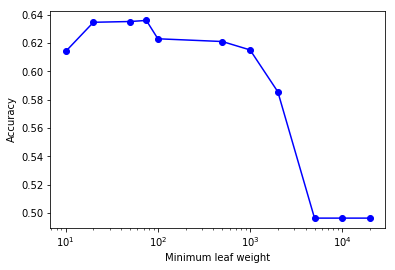

In [28]:
min_weights = [10, 20, 50, 75, 100, 500, 1000, 2000, 5000, 10000, 20000]
accuracies = []
for x in min_weights:
    model = tc.decision_tree_classifier.create(train_data, validation_set=None, 
                                               max_depth=1000, verbose=False, random_seed=1, target=target, 
                                               features=features, min_child_weight = x)
    acc = model.evaluate(validation_data)['accuracy']
    accuracies.append(acc)
    # ...

# plot a graph
plt.plot(min_weights, accuracies,'b-o')
plt.xscale('log')
plt.xlabel('Minimum leaf weight')
plt.ylabel('Accuracy')
print(min_weights[accuracies.index(max(accuracies))])

In [29]:
print(accuracies)

[0.6140672124084446, 0.6346402412753124, 0.6351788022404136, 0.6359327875915554, 0.6230073244291254, 0.6210685049547608, 0.6151443343386471, 0.5856311934510987, 0.496553209823352, 0.496553209823352, 0.496553209823352]


### Q10) Based on your experiment above, what minimum weight would you select?

### Maximum depth + error reduction - Grid Search
Suppose we wanted to consider two stopping conditions together: maximum depth as well as a minimum error reduction. In other words, we stop whenever either of these conditions is true. One approach might be to run more experiments like we did above for `minimum_node_weight`, finding each of these hyperparameters in isolation, then choosing the best one from each of these independent experiments and using both in our final model. However, this often **does not work**, since these *hyperparameters* (parameters to prevent overfitting) might affect each other. For this reason, we must **explore the possible space of hyperparameter values for both conditions at the same time**.

One technique for this two(or more)-dimensional exploration is called [Grid Search](https://en.wikipedia.org/wiki/Hyperparameter_optimization#Grid_search). In this approach, we will explore *all possible combinations* of our candidate hyperparameter values, and choose the one resulting in the highest accuracy. Again, **be careful with which set you use for training and which set you use for evaluating your model**. Please use the following parameters when training your model:
- `validation_set=None`
- `min_child_weight=0` so minimum node weight doesn't affect our model.
- `verbose=False` (unless you want to see lots of output during training)
- `random_seed=1` (so everyone gets the same values)

**Hint**: Remember that `evaluate` returns a dictionary and that you need to extract the desired value from it

We have also included code to graph the accuracy over the space of hyperparameter values. The optimal values of `min_loss_reduction` and `max_depth` that you find should correspond to a peak in this accuracy graph

0.641426109436
('best max_depth:', 7)
('best min loss red', 5)


Text(0.5,0,'Accuracy')

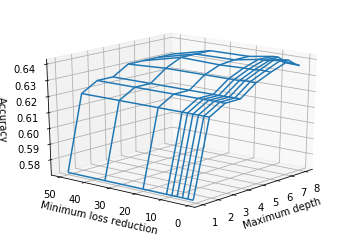

In [30]:
# TODO: best_accuracy = ...  # keep track of current best
max_depths = [1, 2, 3, 4, 5, 6, 7, 8]
min_loss_reductions = [1, 3, 5,  7,  9, 11, 20, 35, 50]
best_accuracy = 0
best_depth = 1
best_min_loss_red =1

# GRAPHING CODE
dimensions = (len(max_depths), len(min_loss_reductions))
graph_depths = np.empty(dimensions)
graph_min_loss_reds = np.empty(dimensions)
graph_accuracies = np.empty(dimensions)
# END GRAPHING CODE

# enumerate gives you both the value `max_depth` and the index `x` as you iterate over `max_depths`
for x, max_depth in enumerate(max_depths):
    # GRAPHING CODE
    curr_iter_accs = np.empty(len(min_loss_reductions))
    # END GRAPHING CODE
    
    for y, min_loss_reduction in enumerate(min_loss_reductions):
        # TODO: fill me in!
        model = tc.decision_tree_classifier.create(train_data, validation_set=None, 
                                                   max_depth=max_depth, verbose=False, random_seed=1, target=target, 
                                                   features=features, min_child_weight = 0, 
                                                   min_loss_reduction=min_loss_reduction)
        acc = model.evaluate(validation_data)['accuracy']
        # ... check best accuracy...
        if acc > best_accuracy:
            best_accuracy = acc
            best_depth=max_depth
            best_min_loss_red = min_loss_reduction
        # ...

        
        # GRAPHING CODE
        curr_iter_accs[y] = acc
        
    graph_depths[x].fill(max_depth)
    graph_min_loss_reds[x] = min_loss_reductions
    graph_accuracies[x] = curr_iter_accs
    
# TODO: don't forget to print out the best accuracy
print(best_accuracy)
print('best max_depth:', best_depth)
print('best min loss red',best_min_loss_red)
# GRAPHING CODE    
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_wireframe(graph_depths, graph_min_loss_reds, graph_accuracies)
ax.view_init(20, 220)
ax.set_xlabel('Maximum depth')
ax.set_ylabel('Minimum loss reduction')
ax.set_zlabel('Accuracy')
# END GRAPHING CODE

### Q11) What was the best combination of `max_depth` and `min_loss_reduction`?

For comparison, let's run the same experiment but just on the `min_loss_reductions` parameter.
Again use 
- `validation_set=None`
- `min_child_weight=0` so minimum node weight doesn't affect our model.
- `verbose=False` (unless you want to see lots of output during training)
- `random_seed=1` (so everyone gets the same values)
- `max_depth=1000` (so the tree can get as deep as it wants)

0.637117621715
('optimal min loss reduction:', 20)


Text(0,0.5,'Accuracy')

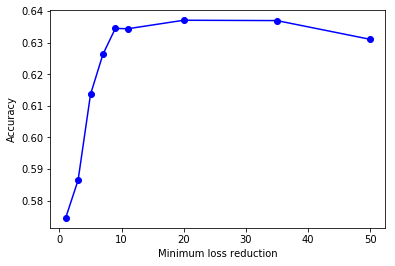

In [31]:
best_min_loss = 1
min_loss_reductions = [1, 3, 5,  7,  9, 11, 20, 35, 50]
accuracies = []
for x in min_loss_reductions:
    # TODO: fill me in!
    model = tc.decision_tree_classifier.create(train_data, validation_set=None,
                                               verbose=False, random_seed=1, target=target, 
                                               features=features, min_child_weight = 0, 
                                               min_loss_reduction=x, max_depth=1000)
    acc = model.evaluate(validation_data)['accuracy']
    # ... check best accuracy...
    # ...
    accuracies.append(acc)
    if acc >= max(accuracies):
        best_min_loss = x
    

# TODO print best accuracy
print(max(accuracies))
print('optimal min loss reduction:', best_min_loss)
# GRAPHING CODE
plt.plot(min_loss_reductions, accuracies,'b-o')
plt.xlabel('Minimum loss reduction')
plt.ylabel('Accuracy')
# END GRAPHING CODE

### Q12) Was the optimal `min_loss_reductions` parameter when only using that stopping condition the same as the one found when using both `min_loss_reductions` AND `max_depth`?
- True
- False

## Quantifying the cost of mistakes

Every mistake the model makes costs money. In this section, we will try and quantify the cost of each mistake made by the model.

Assume the following:

* **False negatives**: Loans that were actually safe but were predicted to be risky. This results in an oppurtunity cost of losing a loan that would have otherwise been accepted. 
* **False positives**: Loans that were actually risky but were predicted to be safe. These are much more expensive because it results in a risky loan being given. 
* **Correct predictions**: All correct predictions don't typically incur any cost.


Let's write code that can compute the cost of mistakes made by the model. Complete the following 4 steps:
1. First, let us compute the predictions made by the model.
1. Second, compute the number of false positives.
2. Third, compute the number of false negatives.
3. Finally, compute the cost of mistakes made by the model by adding up the costs of true positives and false positives.

First, let us make predictions on `validation_data` using the `decision_tree_model`:

In [32]:
predictions = decision_tree_model.predict(validation_data)
validation_data['predictions'] = predictions

**False positives** are predictions where the model predicts +1 but the true label is -1. Complete the following code block for the number of false positives (you may find it helpful to check the [documentation](https://apple.github.io/turicreate/docs/api/generated/turicreate.SArray.html#Numeric) under "Numeric Operators" and "Logical Filters":

In [33]:
false_pos = len(validation_data[(validation_data['safe_loans'] == -1) & (validation_data['predictions'] == 1)])
false_pos

1656

### Q13) How many false positives were predicted by the `decision_tree_model`?

**False negatives** are predictions where the model predicts -1 but the true label is +1. Complete the following code block for the number of false negatives:

In [34]:
false_neg = len(validation_data[(validation_data['safe_loans'] == 1) & (validation_data['predictions'] == -1)])
false_neg

1716

### Q14) how many false negatives were predicted by the `decision_tree_model`?

Let us assume that each mistake costs money:
* Assume a cost of \$10,000 per false negative.
* Assume a cost of \$20,000 per false positive.

### Q15) What is the total cost of mistakes made by `decision_tree_model` on `validation_data`?

In [35]:
total_cost = 10000 * false_neg + 20000 * false_pos
total_cost

50280000